# Assign NK cell annotations

To assemble our annotations, we'll read our clustered NK cell data and assign our expert annotations to those clusters. We'll then inspect the annotations in our UMAP projections, and output final labels for these cells

In [1]:
from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

### Helper function

This function makes it easy to pull csv files stored in HISE as a pandas data.frame

In [2]:
def read_csv_uuid(csv_uuid):
    csv_path = '/home/jupyter/cache/{u}'.format(u = csv_uuid)
    if not os.path.isdir(csv_path):
        hise_res = hisepy.reader.cache_files([csv_uuid])
    csv_filename = os.listdir(csv_path)[0]
    csv_file = '{p}/{f}'.format(p = csv_path, f = csv_filename)
    df = pd.read_csv(csv_file, index_col = 0)
    return df

## Read subclustering results from HISE

In [3]:
cell_class = 'nk-cells'

In [4]:
h5ad_uuid = 'b2a3d1ba-312d-41ec-9e51-8ef4c33192fe'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [5]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [6]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [7]:
adata = sc.read_h5ad(h5ad_file)

In [8]:
adata

AnnData object with n_obs × n_vars = 160848 × 1357
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_reso

## Read annotations

In [10]:
anno_uuid = '60b7bd8f-c55e-47d2-a740-f9b9b9590871'
anno = read_csv_uuid(anno_uuid)

downloading fileID: 60b7bd8f-c55e-47d2-a740-f9b9b9590871
Files have been successfully downloaded!


In [11]:
anno.head()

,leiden_resolution_1.5,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final
0,0,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
1,1,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
2,2,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
3,3,GZMK+ CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
4,4,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes


In [12]:
join_col = 'leiden_resolution_1.5'

In [13]:
anno[join_col] = anno[join_col].astype('string').astype('category')

In [14]:
obs = adata.obs

In [15]:
sum(obs[join_col].isin(anno[join_col]))

160848

In [16]:
obs_anno = obs.merge(anno, how = 'left', on = join_col)

In [17]:
adata.obs = obs_anno
adata.obs = adata.obs.set_index('barcodes', drop = False)

In [18]:
adata.obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final
barcodes,,,,,,,,,,,,,,,,,,,,,
cf72d2f048b611ea8957bafe6d70929e,cf72d2f048b611ea8957bafe6d70929e,B001,shrewd_chocolaty_xrayfish,cf72d2f048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1229,51,8644,...,4,3,3,3,GZMK+ CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
cf73d29048b611ea8957bafe6d70929e,cf73d29048b611ea8957bafe6d70929e,B001,subocean_bold_oriole,cf73d29048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2005,246,18676,...,4,8,11,13,NK+T Doublets,NK cell,Yes,NK+T Doublets,Yes,Yes
cf73ecda48b611ea8957bafe6d70929e,cf73ecda48b611ea8957bafe6d70929e,B001,observant_fathomable_barracuda,cf73ecda48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,921,37,5216,...,4,1,1,0,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
cf7430b448b611ea8957bafe6d70929e,cf7430b448b611ea8957bafe6d70929e,B001,omniscient_slim_hoki,cf7430b448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2153,117,16241,...,4,0,0,1,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes
cf754e0448b611ea8957bafe6d70929e,cf754e0448b611ea8957bafe6d70929e,B001,glossy_intimate_ladybug,cf754e0448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1497,131,9952,...,4,12,15,18,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

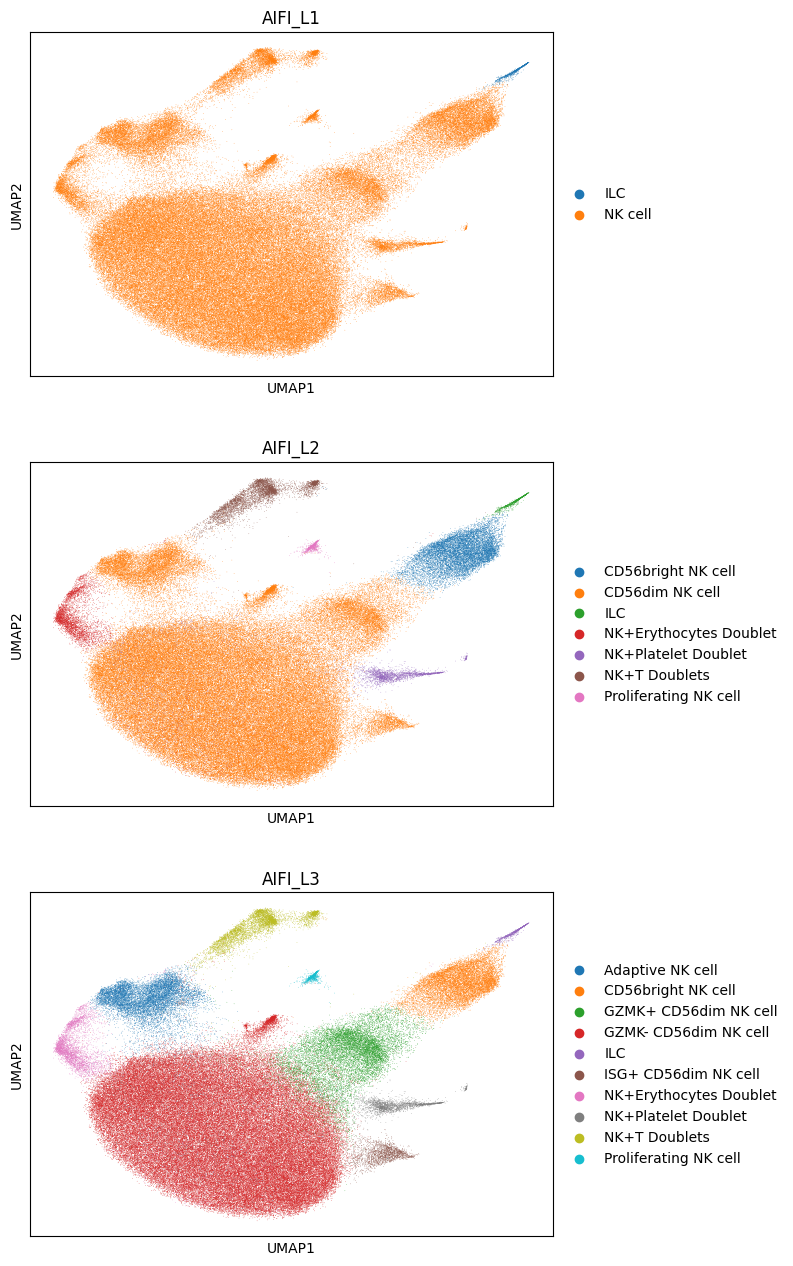

In [19]:
sc.pl.umap(adata, color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'], ncols = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

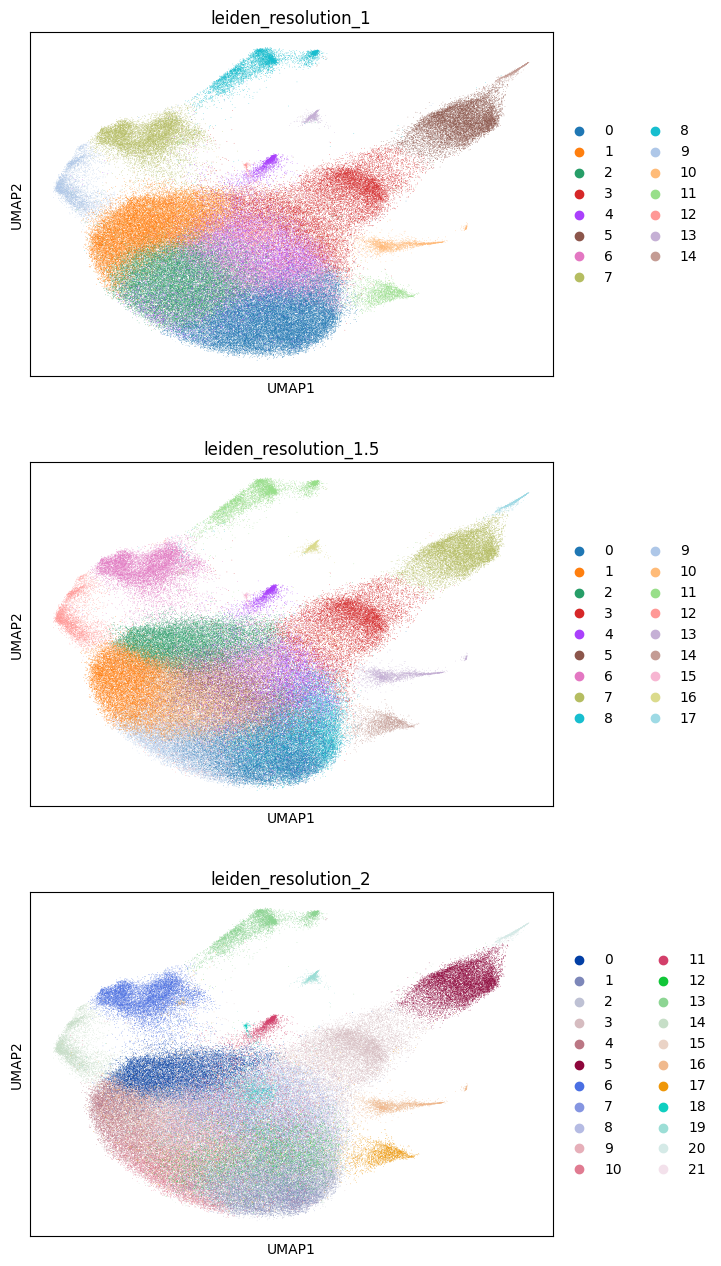

In [20]:
sc.pl.umap(adata, 
           color = ['leiden_resolution_1',
                    'leiden_resolution_1.5',
                    'leiden_resolution_2'],
           ncols = 1)

## Output final annotations

In [21]:
obs = adata.obs
obs = obs.reset_index(drop = True)

In [22]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [23]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden_resolution_1.5,leiden_resolution_2,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final,umap_1,umap_2
0,cf72d2f048b611ea8957bafe6d70929e,B001,shrewd_chocolaty_xrayfish,cf72d2f048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1229,51,8644,...,3,3,GZMK+ CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes,0.883505,7.876848
1,cf73d29048b611ea8957bafe6d70929e,B001,subocean_bold_oriole,cf73d29048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2005,246,18676,...,11,13,NK+T Doublets,NK cell,Yes,NK+T Doublets,Yes,Yes,-0.265153,12.770269
2,cf73ecda48b611ea8957bafe6d70929e,B001,observant_fathomable_barracuda,cf73ecda48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,921,37,5216,...,1,0,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes,-2.538007,7.109251
3,cf7430b448b611ea8957bafe6d70929e,B001,omniscient_slim_hoki,cf7430b448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2153,117,16241,...,0,1,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes,-0.433553,3.528103
4,cf754e0448b611ea8957bafe6d70929e,B001,glossy_intimate_ladybug,cf754e0448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1497,131,9952,...,15,18,GZMK- CD56dim NK cell,NK cell,Yes,CD56dim NK cell,Yes,Yes,0.191648,5.767444


In [24]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [ ]:
obs_out_csv = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/

In [ ]:
obs_out_parquet = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [ ]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [ ]:
label_out_csv = '{p}/ref_pbmc_{c}_barcode_labels_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [ ]:
label_out_parquet = '{p}/ref_pbmc_{c}_barcode_labels_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Upload annotations to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [ ]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'NK cell barcode annotations {d}'.format(d = date.today())

In [ ]:
in_files = [h5ad_uuid, dc_uuid, anno_uuid, dc_anno_uuid]

In [51]:
in_files

['c38df326-662d-459b-982d-0186c022f70d',
 '892e4fb0-8dad-4cb6-bcec-8f29b3dcd15e',
 '9f7d59f2-7aa8-4c2a-86b9-fe6c46b1068f',
 '98c74523-e518-49f3-a021-f30b87a8f565']

In [52]:
out_files = [obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [53]:
out_files

['output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.csv',
 'output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.parquet',
 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.csv',
 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.parquet']

In [54]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/18-Python_assign_Myeloid_cells.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/17-Python_assign_B_cells.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/04-Annotation/16-Python_T_cell_annotations.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.csv', 'output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.parquet', 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.csv', 'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'af36dae2-5608-499b-9a8f-845162d31035',
 'files': ['output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.csv',
  'output/ref_pbmc_myeloid_labeled_meta_umap_2024-02-29.parquet',
  'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.csv',
  'output/ref_pbmc_myeloid_barcode_labels_2024-02-29.parquet']}

In [55]:
import session_info
session_info.show()